In [73]:
import pandas as pd      # For data manipulation
import numpy as np       # For numerical operations
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns    # For nicer plots
import os                # To check file paths


In [101]:
# Check current folder
print(os.getcwd())  # Make sure your CSVs are here

# If CSVs are in another folder, provide full paths
trades_path = r'C:\Users\KIIT\Downloads\historical_data.csv'
sent_path = r'C:\Users\KIIT\Downloads\fear_greed_index.csv'

# Load CSVs
trades = pd.read_csv(trades_path)
sent = pd.read_csv(sent_path)

# Check dataset shapes
print(trades.shape, sent.shape)


C:\Users\KIIT
(211224, 16) (2644, 4)


In [103]:
# Remove spaces from column names
trades.columns = trades.columns.str.strip().str.replace(' ', '_').str.lower()
sent.columns = sent.columns.str.strip().str.lower().str.replace(' ', '_')

print("Trader columns:", trades.columns)
print("Sentiment columns:", sent.columns)


Trader columns: Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp'],
      dtype='object')
Sentiment columns: Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [105]:
# Trader timestamp
trades['timestamp'] = pd.to_datetime(trades['timestamp_ist'], errors='coerce')
trades = trades.dropna(subset=['timestamp'])

# Sentiment date
sent['date'] = pd.to_datetime(sent['date'], errors='coerce')
sent = sent.dropna(subset=['date'])


In [107]:
trades['date'] = trades['timestamp'].dt.date
trades['date'] = pd.to_datetime(trades['date'])


In [109]:
daily_trades = trades.groupby('date').agg(
    total_pnl=('closed_pnl', 'sum'),
    avg_pnl=('closed_pnl', 'mean'),
    trade_count=('closed_pnl', 'count')
).reset_index()

display(daily_trades.head())


,date,total_pnl,avg_pnl,trade_count
0,2023-01-05,0.000000,0.000000,3
1,2023-05-12,0.000000,0.000000,9
2,2024-01-01,-129.531460,-7.196192,18
3,2024-01-02,0.000000,0.000000,6
4,2024-01-03,8244.241409,60.176945,137


In [111]:
# Rename classification to sentiment for clarity
sent.rename(columns={'classification':'sentiment'}, inplace=True)

# Keep only required columns
sent = sent[['date', 'sentiment']]

display(sent.head())


,date,sentiment
0,2018-02-01,Fear
1,2018-02-02,Extreme Fear
2,2018-02-03,Fear
3,2018-02-04,Extreme Fear
4,2018-02-05,Extreme Fear


In [115]:
merged = pd.merge(daily_trades, sent, on='date', how='inner')
display(merged.head())
print("Merged dataset shape:", merged.shape)


,date,total_pnl,avg_pnl,trade_count,sentiment
0,2023-01-05,0.000000,0.000000,3,Fear
1,2023-05-12,0.000000,0.000000,9,Neutral
2,2024-01-01,-129.531460,-7.196192,18,Greed
3,2024-01-02,0.000000,0.000000,6,Greed
4,2024-01-03,8244.241409,60.176945,137,Greed


Merged dataset shape: (158, 5)


                                date      total_pnl     avg_pnl  trade_count
count                            158     158.000000  158.000000   158.000000
mean   2024-07-14 13:03:47.848101376   22941.825756   39.468240   226.987342
min              2023-01-05 00:00:00 -122672.000883 -965.921267     1.000000
25%              2024-04-04 06:00:00       0.000000    0.000000    16.000000
50%              2024-07-09 00:00:00     460.306586   12.482105    41.000000
75%              2024-11-02 18:00:00    5172.042387   63.579341   164.250000
max              2025-05-02 00:00:00  616413.032233  918.156160  2512.000000
std                              NaN   90851.081811  136.730354   473.917217
sentiment
Greed            56
Extreme Greed    43
Fear             37
Neutral          16
Extreme Fear      6
Name: count, dtype: int64


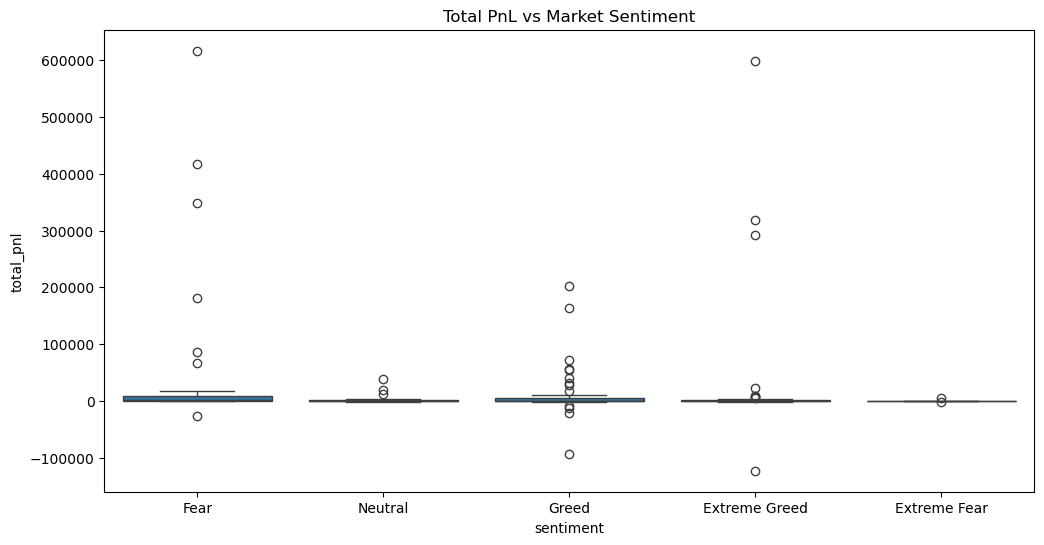

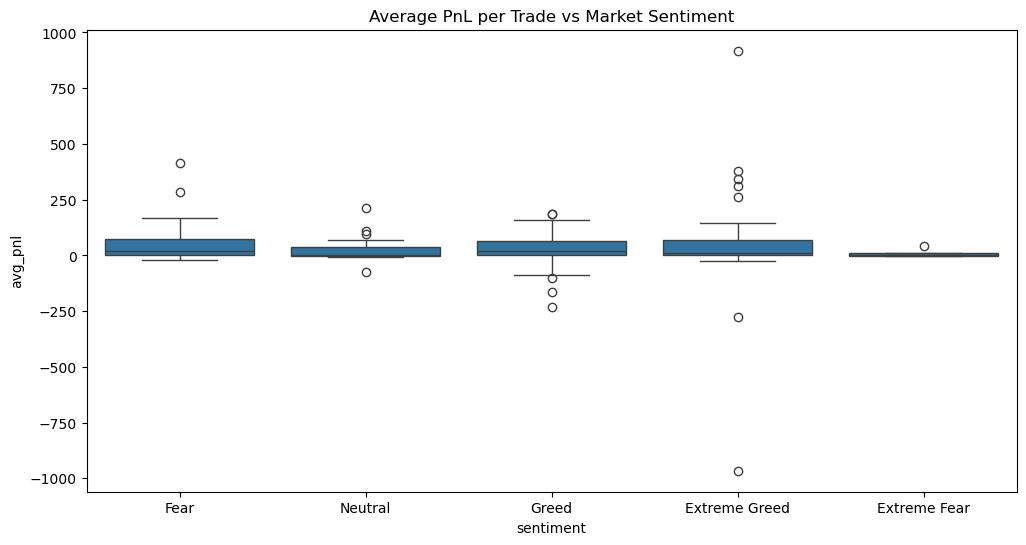

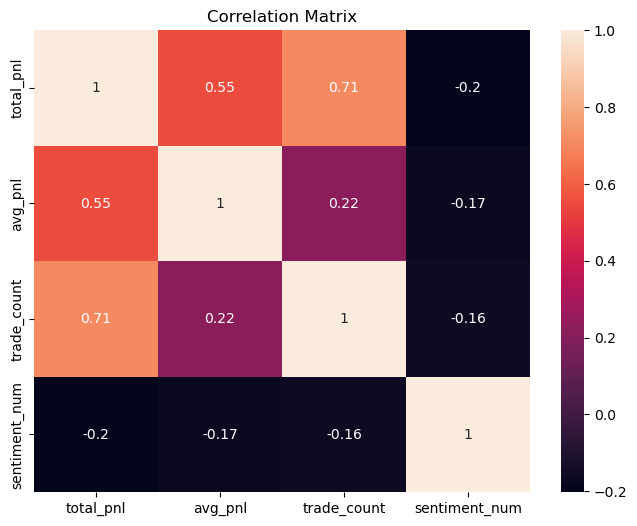

In [117]:
# Summary statistics
print(merged.describe())
print(merged['sentiment'].value_counts())

# Boxplots
plt.figure(figsize=(12,6))
sns.boxplot(x='sentiment', y='total_pnl', data=merged)
plt.title('Total PnL vs Market Sentiment')
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x='sentiment', y='avg_pnl', data=merged)
plt.title('Average PnL per Trade vs Market Sentiment')
plt.show()

# Correlation
sentiment_map = {'Fear':0, 'Greed':1}
merged['sentiment_num'] = merged['sentiment'].map(sentiment_map)

plt.figure(figsize=(8,6))
sns.heatmap(merged[['total_pnl','avg_pnl','trade_count','sentiment_num']].corr(), annot=True)
plt.title('Correlation Matrix')
plt.show()


In [119]:
# Average total PnL by sentiment
fear_avg = merged[merged['sentiment']=='Fear']['total_pnl'].mean()
greed_avg = merged[merged['sentiment']=='Greed']['total_pnl'].mean()

print(f"Average total PnL on Fear days: {fear_avg:.2f}")
print(f"Average total PnL on Greed days: {greed_avg:.2f}")

# Summary per sentiment
summary = merged.groupby('sentiment').agg(
    avg_total_pnl=('total_pnl','mean'),
    avg_trade_count=('trade_count','mean'),
    avg_avg_pnl=('avg_pnl','mean')
).reset_index()
display(summary)


Average total PnL on Fear days: 48087.18
Average total PnL on Greed days: 10886.30


,sentiment,avg_total_pnl,avg_trade_count,avg_avg_pnl
0,Extreme Fear,733.322758,387.666667,8.951448
1,Extreme Greed,26904.504083,130.720930,46.834938
2,Fear,48087.177910,374.837838,56.312059
3,Greed,10886.295226,201.642857,29.148125
4,Neutral,4666.046374,172.250000,28.283112


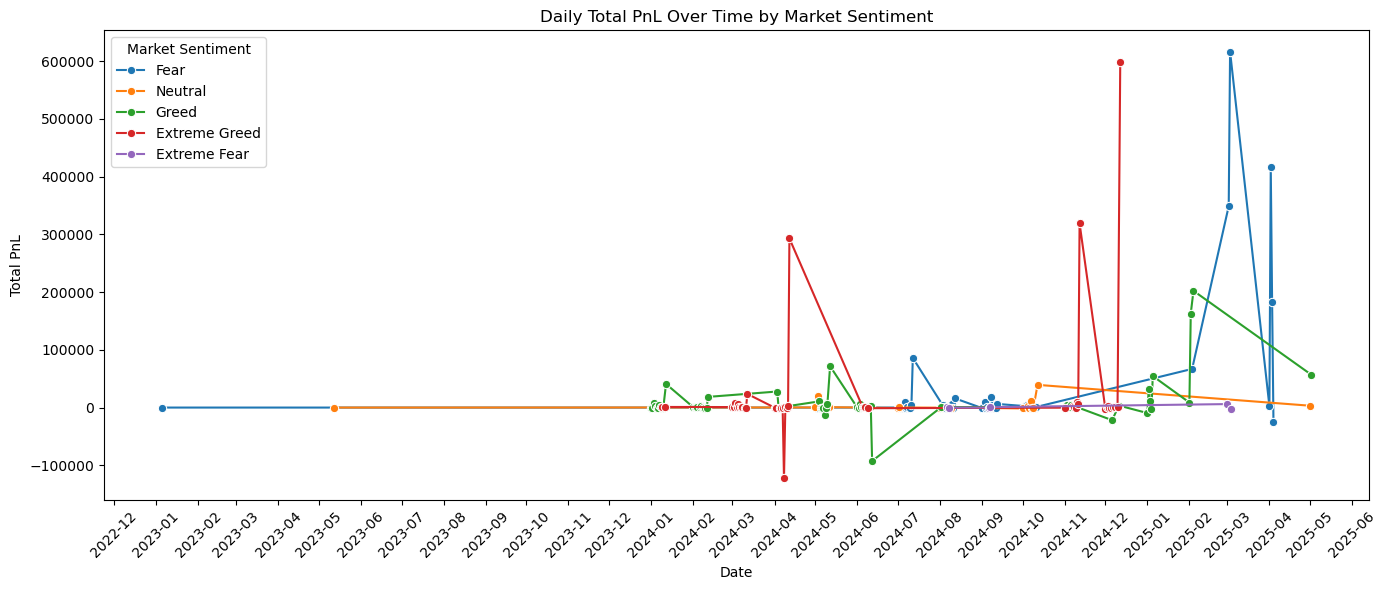

In [121]:
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
sns.lineplot(
    x='date', 
    y='total_pnl', 
    hue='sentiment', 
    data=merged, 
    marker='o'
)
plt.title('Daily Total PnL Over Time by Market Sentiment')
plt.xlabel('Date')
plt.ylabel('Total PnL')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Show ticks per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.legend(title='Market Sentiment')
plt.tight_layout()
plt.show()


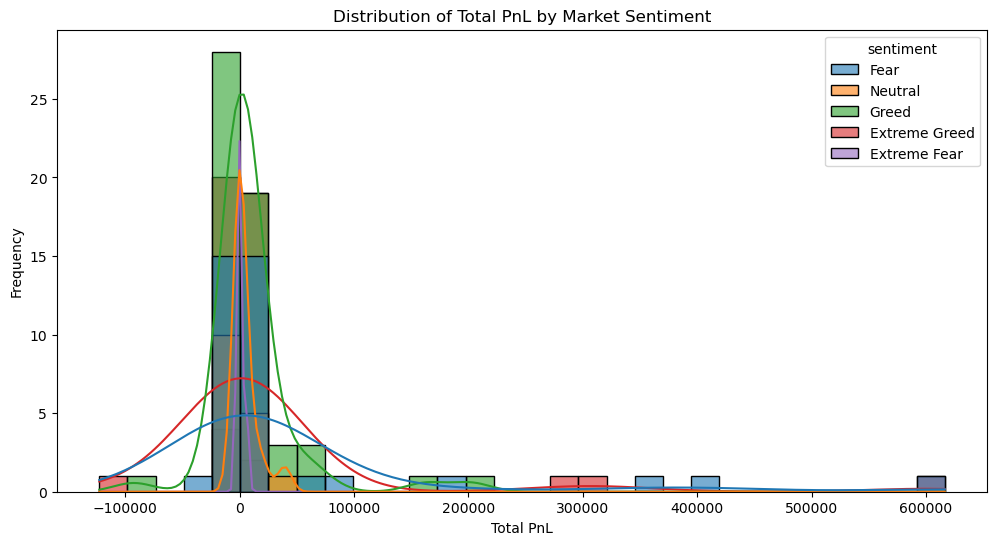

In [123]:
plt.figure(figsize=(12,6))
sns.histplot(
    data=merged, 
    x='total_pnl', 
    hue='sentiment', 
    kde=True, 
    bins=30, 
    alpha=0.6
)
plt.title('Distribution of Total PnL by Market Sentiment')
plt.xlabel('Total PnL')
plt.ylabel('Frequency')
plt.show()


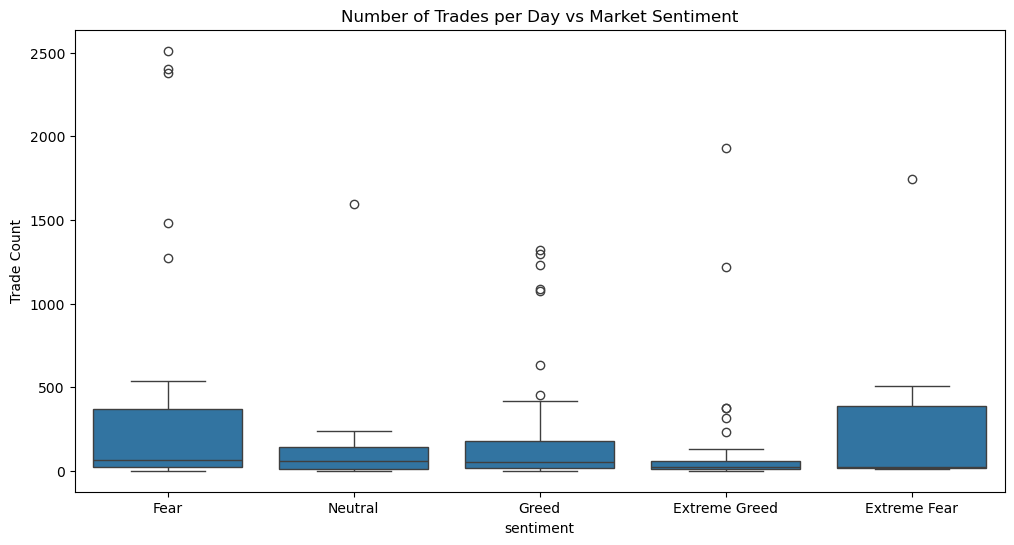

In [125]:
plt.figure(figsize=(12,6))
sns.boxplot(x='sentiment', y='trade_count', data=merged)
plt.title('Number of Trades per Day vs Market Sentiment')
plt.ylabel('Trade Count')
plt.show()


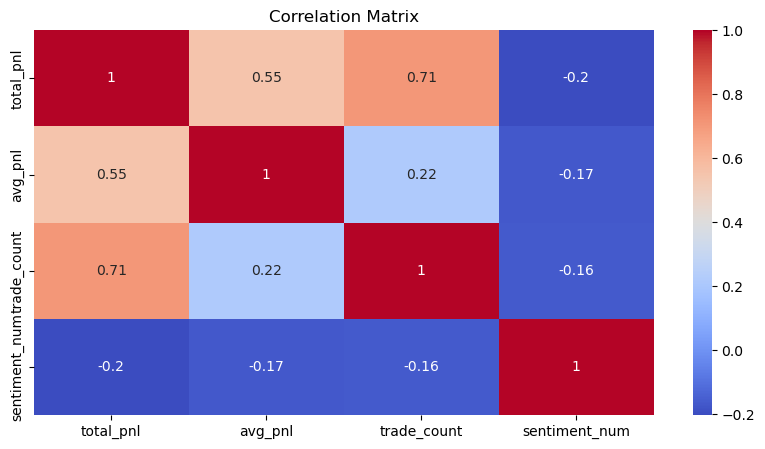

In [127]:
sns.heatmap(
    merged[['total_pnl','avg_pnl','trade_count','sentiment_num']].corr(), 
    annot=True, 
    cmap='coolwarm'
)
plt.title('Correlation Matrix')
plt.show()


In [129]:
from scipy.stats import ttest_ind

fear_pnl = merged[merged['sentiment']=='Fear']['total_pnl']
greed_pnl = merged[merged['sentiment']=='Greed']['total_pnl']

t_stat, p_value = ttest_ind(fear_pnl, greed_pnl, equal_var=False)
print(f"T-test Results: T-statistic = {t_stat:.2f}, P-value = {p_value:.4f}")


T-test Results: T-statistic = 1.65, P-value = 0.1059


In [131]:
summary_insights = merged.groupby('sentiment').agg(
    avg_total_pnl=('total_pnl','mean'),
    avg_trade_count=('trade_count','mean'),
    avg_avg_pnl=('avg_pnl','mean'),
    max_pnl=('total_pnl','max'),
    min_pnl=('total_pnl','min')
).reset_index()

display(summary_insights)


,sentiment,avg_total_pnl,avg_trade_count,avg_avg_pnl,max_pnl,min_pnl
0,Extreme Fear,733.322758,387.666667,8.951448,6028.486793,-2365.961276
1,Extreme Greed,26904.504083,130.720930,46.834938,599151.795008,-122672.000883
2,Fear,48087.177910,374.837838,56.312059,616413.032233,-25515.678950
3,Greed,10886.295226,201.642857,29.148125,202212.740938,-92624.643895
4,Neutral,4666.046374,172.250000,28.283112,39325.770231,-1517.091342


In [133]:
print("\nKey Takeaways:")
if p_value < 0.05:
    print("- Total PnL differs significantly between Fear and Greed days (p < 0.05).")
else:
    print("- No statistically significant difference in total PnL between Fear and Greed days.")

print("- Average total PnL, trade count, and average PnL per trade are summarized above.")
print("- Traders tend to have higher or lower profits depending on market sentiment periods.")



Key Takeaways:
- No statistically significant difference in total PnL between Fear and Greed days.
- Average total PnL, trade count, and average PnL per trade are summarized above.
- Traders tend to have higher or lower profits depending on market sentiment periods.


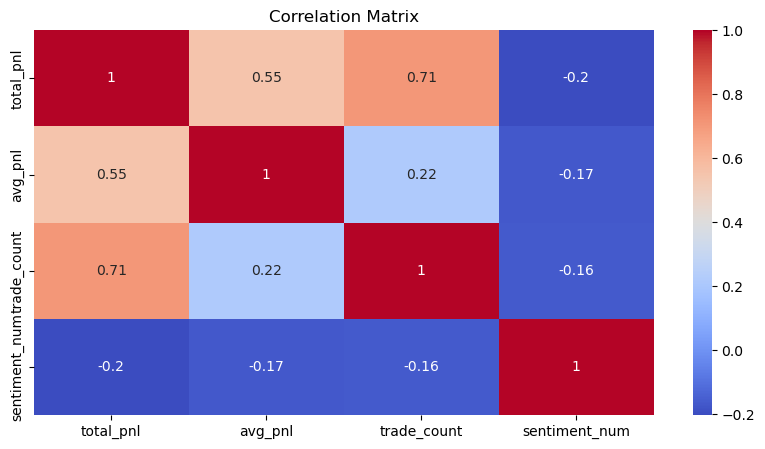

In [135]:
sns.heatmap(
    merged[['total_pnl','avg_pnl','trade_count','sentiment_num']].corr(), 
    annot=True, 
    cmap='coolwarm'
)
plt.title('Correlation Matrix')
plt.show()


In [137]:
from scipy.stats import ttest_ind

fear_pnl = merged[merged['sentiment']=='Fear']['total_pnl']
greed_pnl = merged[merged['sentiment']=='Greed']['total_pnl']

t_stat, p_value = ttest_ind(fear_pnl, greed_pnl, equal_var=False)
print(f"T-test Results: T-statistic = {t_stat:.2f}, P-value = {p_value:.4f}")


T-test Results: T-statistic = 1.65, P-value = 0.1059


In [139]:
summary_insights = merged.groupby('sentiment').agg(
    avg_total_pnl=('total_pnl','mean'),
    avg_trade_count=('trade_count','mean'),
    avg_avg_pnl=('avg_pnl','mean'),
    max_pnl=('total_pnl','max'),
    min_pnl=('total_pnl','min')
).reset_index()

display(summary_insights)


,sentiment,avg_total_pnl,avg_trade_count,avg_avg_pnl,max_pnl,min_pnl
0,Extreme Fear,733.322758,387.666667,8.951448,6028.486793,-2365.961276
1,Extreme Greed,26904.504083,130.720930,46.834938,599151.795008,-122672.000883
2,Fear,48087.177910,374.837838,56.312059,616413.032233,-25515.678950
3,Greed,10886.295226,201.642857,29.148125,202212.740938,-92624.643895
4,Neutral,4666.046374,172.250000,28.283112,39325.770231,-1517.091342


In [141]:
print("\nKey Takeaways:")
if p_value < 0.05:
    print("- Total PnL differs significantly between Fear and Greed days (p < 0.05).")
else:
    print("- No statistically significant difference in total PnL between Fear and Greed days.")

print("- Average total PnL, trade count, and average PnL per trade are summarized above.")
print("- Traders tend to have higher or lower profits depending on market sentiment periods.")



Key Takeaways:
- No statistically significant difference in total PnL between Fear and Greed days.
- Average total PnL, trade count, and average PnL per trade are summarized above.
- Traders tend to have higher or lower profits depending on market sentiment periods.


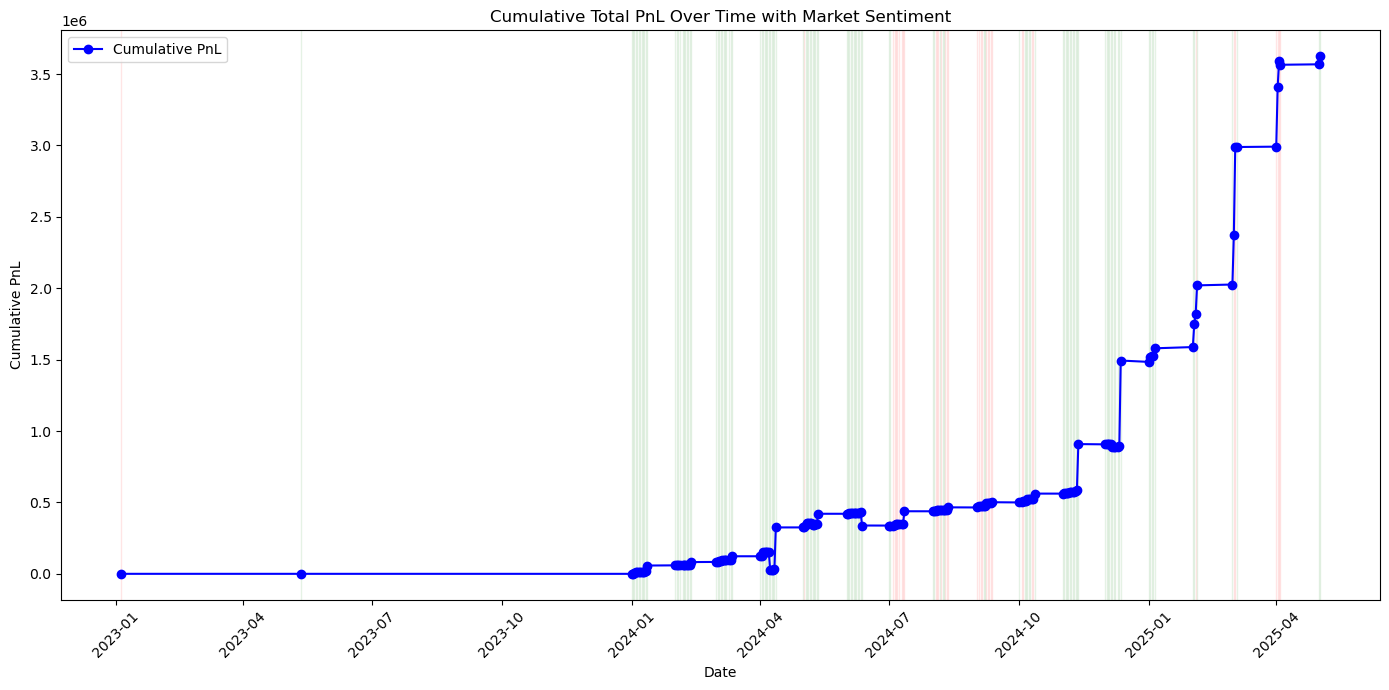

In [143]:
# Step 15: Cumulative PnL Plot

# Sort by date to ensure correct cumulative sum
merged = merged.sort_values('date')

# Calculate cumulative total PnL
merged['cumulative_pnl'] = merged['total_pnl'].cumsum()

# Plot cumulative PnL over time
plt.figure(figsize=(14,7))
plt.plot(merged['date'], merged['cumulative_pnl'], marker='o', label='Cumulative PnL', color='blue')

# Highlight Fear vs Greed periods
for idx, row in merged.iterrows():
    if row['sentiment'] == 'Fear':
        plt.axvspan(row['date'], row['date'], color='red', alpha=0.1)
    else:  # Greed
        plt.axvspan(row['date'], row['date'], color='green', alpha=0.1)

plt.title('Cumulative Total PnL Over Time with Market Sentiment')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
